# Analyzing public comments about the AI Executive Order
1) Explore the sentiment of the comments\
2) Find common topics\
3) Summarize comments\
4) Summarize comments related to particular keyword\
5) **Bonus**: Save the attachments related to the comments 

In [406]:
import os
import re
import uuid
from math import log
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
# Download the stopwords dataset if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

from gensim import corpora, models
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/Nel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Nel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [407]:
# https://www.regulations.gov/document/OSTP-TECH-2023-0007-0001
df = pd.read_csv('lp6-0cm8-2tqm.csv')
df.head()

,Document ID,Agency ID,Docket ID,Tracking Number,Document Type,Posted Date,Is Withdrawn?,Federal Register Number,FR Citation,Title,...,Government Agency,Government Agency Type,Comment,Category,Restrict Reason Type,Restrict Reason,Reason Withdrawn,Content Files,Attachment Files,"Display Properties (Name, Label, Tooltip)"
0,OSTP-TECH-2023-0007-0001,OSTP,OSTP-TECH-2023-0007,NaN,Notice,2023-05-26T04:00Z,False,2023-11346,NaN,Request for Information: National Priorities f...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/OSTP-TECH-20...,NaN,NaN
1,OSTP-TECH-2023-0007-0002,OSTP,OSTP-TECH-2023-0007,li6-a0d4-mviw,Public Submission,2023-10-30T04:00Z,False,NaN,NaN,Comment on FR Doc # 2023-11346,...,NaN,NaN,AI has the opportunity to enhance the lives of...,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/OSTP-TECH-20...,NaN
2,OSTP-TECH-2023-0007-0003,OSTP,OSTP-TECH-2023-0007,li4-r6na-7w30,Public Submission,2023-10-30T04:00Z,False,NaN,NaN,Comment on FR Doc # 2023-11346,...,NaN,NaN,I asked an AI app if there were entities that ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OSTP-TECH-2023-0007-0004,OSTP,OSTP-TECH-2023-0007,li4-sj09-8wym,Public Submission,2023-10-30T04:00Z,False,NaN,NaN,Comment on FR Doc # 2023-11346,...,NaN,NaN,We can and must develop a National Trustworthy...,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/OSTP-TECH-20...,NaN
4,OSTP-TECH-2023-0007-0005,OSTP,OSTP-TECH-2023-0007,li4-q24j-j60p,Public Submission,2023-10-30T04:00Z,False,NaN,NaN,Comment on FR Doc # 2023-11346,...,NaN,NaN,OSTP_FRDOC_0001-0006\n\nIf AI violates an Indi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [408]:
df.shape

(386, 60)

In [409]:
df.columns

Index(['Document ID', 'Agency ID', 'Docket ID', 'Tracking Number',
       'Document Type', 'Posted Date', 'Is Withdrawn?',
       'Federal Register Number', 'FR Citation', 'Title', 'Comment Start Date',
       'Comment Due Date', 'Allow Late Comments', 'Comment on Document ID',
       'Effective Date', 'Implementation Date', 'Postmark Date',
       'Received Date', 'Author Date', 'Related RIN(s)', 'Authors', 'CFR',
       'Abstract', 'Legacy ID', 'Media', 'Document Subtype',
       'Exhibit Location', 'Exhibit Type', 'Additional Field 1',
       'Additional Field 2', 'Topics', 'Duplicate Comments',
       'OMB/PRA Approval Number', 'Page Count', 'Page Length', 'Paper Width',
       'Special Instructions', 'Source Citation', 'Start End Page', 'Subject',
       'First Name', 'Last Name', 'City', 'State/Province', 'Zip/Postal Code',
       'Country', 'Organization Name', 'Submitter Representative',
       'Representative's Address', 'Representative's City, State & Zip',
       'Government

## Sentiment Analysis

In [411]:
dfComments = df[~((df['Comment'].isna()) & ~(df['Comment'].str.contains('attached')))]
dfComments.head()

TypeError: bad operand type for unary ~: 'float'

In [8]:
def clean_text(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

def get_text_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(clean_text(tweet)) 
    # set sentiment 
    return analysis.sentiment.polarity

In [9]:
dfComments['sentiment'] = dfComments.apply(lambda x: get_text_sentiment(x['Comment']), 1)

/var/folders/p_/fdsmk_y5351dd5j2n847ztd40000gn/T/ipykernel_31522/3391385899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfComments['sentiment'] = dfComments.apply(lambda x: get_text_sentiment(x['Comment']), 1)


In [20]:
dfComments['clean_text'] = dfComments.apply(lambda x: clean_text(x['Comment'].lower()), 1)
dfComments.head()

/var/folders/p_/fdsmk_y5351dd5j2n847ztd40000gn/T/ipykernel_31522/1366416000.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfComments['clean_text'] = dfComments.apply(lambda x: clean_text(x['Comment'].lower()), 1)


,Document ID,Agency ID,Docket ID,Tracking Number,Document Type,Posted Date,Is Withdrawn?,Federal Register Number,FR Citation,Title,...,Comment,Category,Restrict Reason Type,Restrict Reason,Reason Withdrawn,Content Files,Attachment Files,"Display Properties (Name, Label, Tooltip)",sentiment,clean_text
2,OSTP-TECH-2023-0007-0003,OSTP,OSTP-TECH-2023-0007,li4-r6na-7w30,Public Submission,2023-10-30T04:00Z,False,NaN,NaN,Comment on FR Doc # 2023-11346,...,I asked an AI app if there were entities that ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084524,i asked an ai app if there were entities that ...
3,OSTP-TECH-2023-0007-0004,OSTP,OSTP-TECH-2023-0007,li4-sj09-8wym,Public Submission,2023-10-30T04:00Z,False,NaN,NaN,Comment on FR Doc # 2023-11346,...,We can and must develop a National Trustworthy...,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/OSTP-TECH-20...,NaN,0.400000,we can and must develop a national trustworthy...
4,OSTP-TECH-2023-0007-0005,OSTP,OSTP-TECH-2023-0007,li4-q24j-j60p,Public Submission,2023-10-30T04:00Z,False,NaN,NaN,Comment on FR Doc # 2023-11346,...,OSTP_FRDOC_0001-0006\n\nIf AI violates an Indi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.100000,ostp frdoc 0001 0006 if ai violates an individ...
6,OSTP-TECH-2023-0007-0007,OSTP,OSTP-TECH-2023-0007,li9-as6p-73j8,Public Submission,2023-10-30T04:00Z,False,NaN,NaN,Comment on FR Doc # 2023-11346,...,AI-generated content will be the literal death...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222222,ai generated content will be the literal death...
7,OSTP-TECH-2023-0007-0008,OSTP,OSTP-TECH-2023-0007,lia-qtr7-jxpg,Public Submission,2023-10-30T04:00Z,False,NaN,NaN,Comment on FR Doc # 2023-11346,...,There is much angst over the emergence of ‘gen...,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/OSTP-TECH-20...,NaN,0.132899,there is much angst over the emergence of gene...


In [31]:
dfComments.sentiment.describe()

count    189.000000
mean       0.071809
std        0.143807
min       -0.600000
25%        0.015909
50%        0.080921
75%        0.143750
max        0.750000
Name: sentiment, dtype: float64

<Axes: >

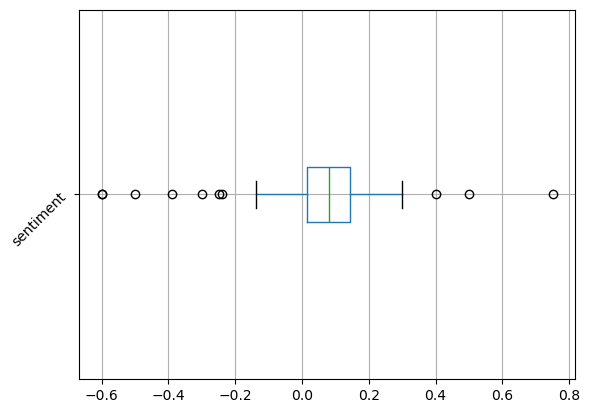

In [270]:
dfComments.boxplot(column='sentiment', vert=False, rot=45)

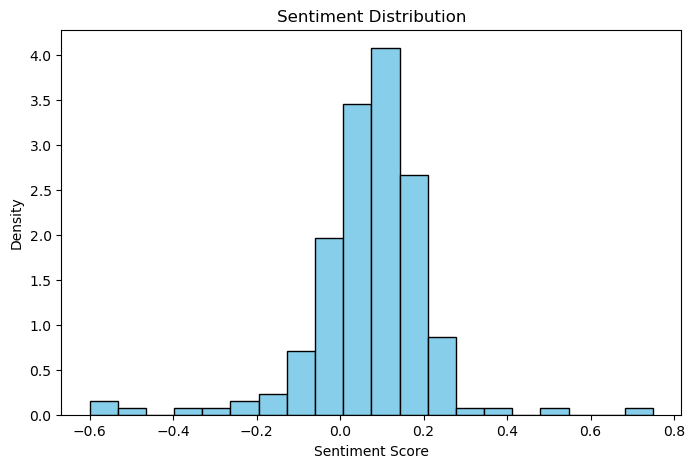

In [272]:
# Plotting the distribution curve
plt.figure(figsize=(8, 5))
plt.hist(dfComments['sentiment'], bins=20, edgecolor='black', color='skyblue', density=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()


In [62]:
for index, row in dfComments[dfComments.sentiment < 0].iterrows():
    print(row['clean_text'])
    print('\n')

ostp frdoc 0001 0006 if ai violates an individuals 5th amendment rights that individual must be compensated and awarded damages cruel practices have taken place involving ai and the victims of these practices must be awarded damages and compensated in good faith


on the topic of artificial intelligence there are 3 important focus areas 1 copyrights and infringement of copyright while collecting artificial intelligence databases and the training of the ai models 2 safety of the system once it becomes widely available and used 3 benefits what we can currently see from the ai systems first the copyright issue is very significant copyright is over hundred year old regulation and usually technologies that cannot respect copyright s limitations should not be built at all many technology vendors me included have rejected ai technology area completely because there isn t viable plan how to solve the ai s database collection copyright problem the technology requires too large amount of data an

## Treemap

In [278]:
word_tokenize('word testing 123')

['word', 'testing', '123']

In [85]:
# Assuming your DataFrame is named dfComments and the column is 'Comment'
comments = dfComments['Comment']

# Step 1: Preprocess the text data
comments = comments.str.lower().replace('[^\w\s]', '', regex=True)

# Step 2: Tokenize and remove stopwords using NLTK
stop_words = set(stopwords.words('english'))
comments = comments.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))


In [86]:
# Create a CountVectorizer instance
vectorizer = CountVectorizer()

In [87]:
# Fit and transform the comments to get the term frequencies
X = vectorizer.fit_transform(comments)

In [286]:
print(vectorizer.transform(['ai here to stay forever']))

  (0, 230)	1
  (0, 2056)	1
  (0, 4685)	1


In [288]:
vectorizer.get_feature_names_out()

array(['02', '10', '100', ..., 'youve', 'zero', 'zuccarelli'],
      dtype=object)

In [88]:
# Convert the result to a DataFrame
term_frequency_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [89]:
# Sum the term frequencies along the rows to get total counts for each term
total_counts = term_frequency_df.sum()

In [175]:
# Create a DataFrame with 'Word' and 'Count'
word_count_df = pd.DataFrame({'Word': total_counts.index, 'Count': total_counts.values})

In [176]:
# Display the word count DataFrame
print(word_count_df)

            Word  Count
0             02      1
1             10      6
2            100      4
3           1000      3
4           1002      1
...          ...    ...
5468       youth      1
5469     youtube      2
5470       youve      1
5471        zero      5
5472  zuccarelli      1

[5473 rows x 2 columns]


In [193]:
scaling = log(log(word_count_df['Count'].max())+1)

In [194]:
word_count_df['Scale'] = word_count_df['Count'].apply(lambda x: log(log(x)+1))/scaling

In [199]:
# Sort the DataFrame by frequency in descending order
wdf = word_count_df.sort_values(by='Count', ascending=False)[:50]

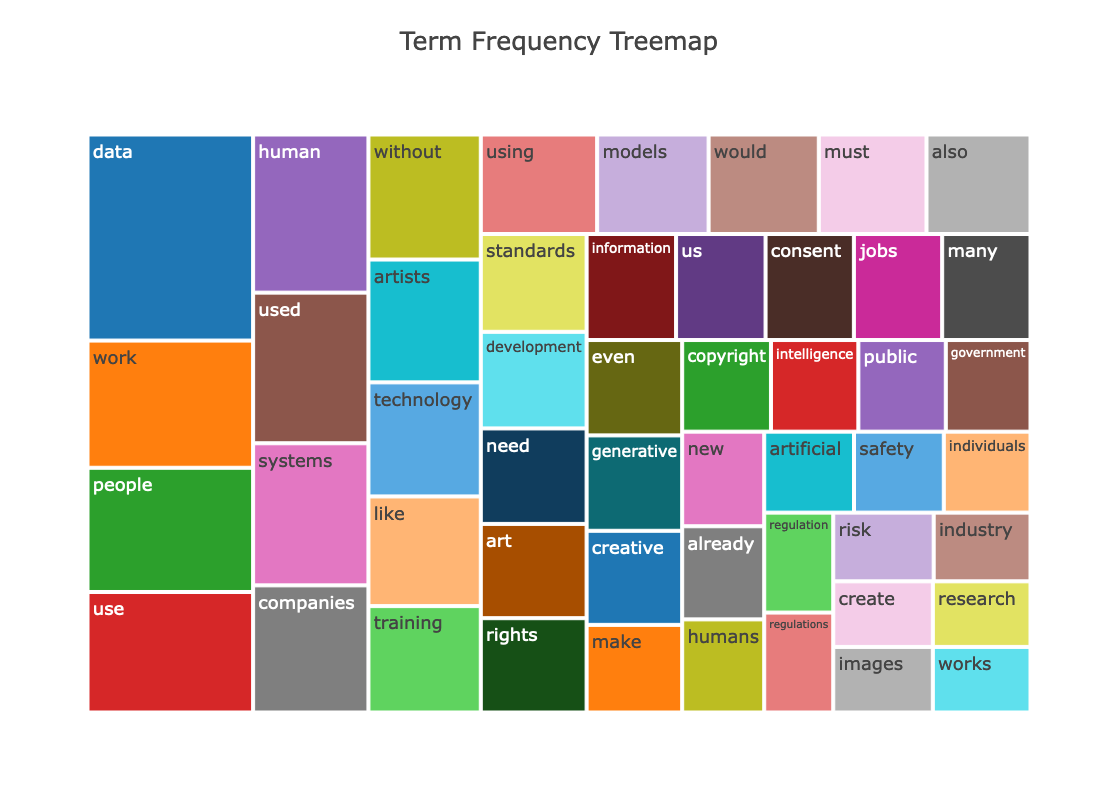

In [274]:
# Create a treemap using plotly express
fig = px.treemap(wdf, path=['Word'], values='Count', color='Scale',
                 color_continuous_scale='Portland',
                 title='Term Frequency Treemap', 
                 width=850, height=800, 
                 template='presentation',
                )

# Show the plot
fig.show()

In [205]:
# Sort the DataFrame by frequency in descending order
wdf = word_count_df.sort_values(by='Count', ascending=False)[1:51]

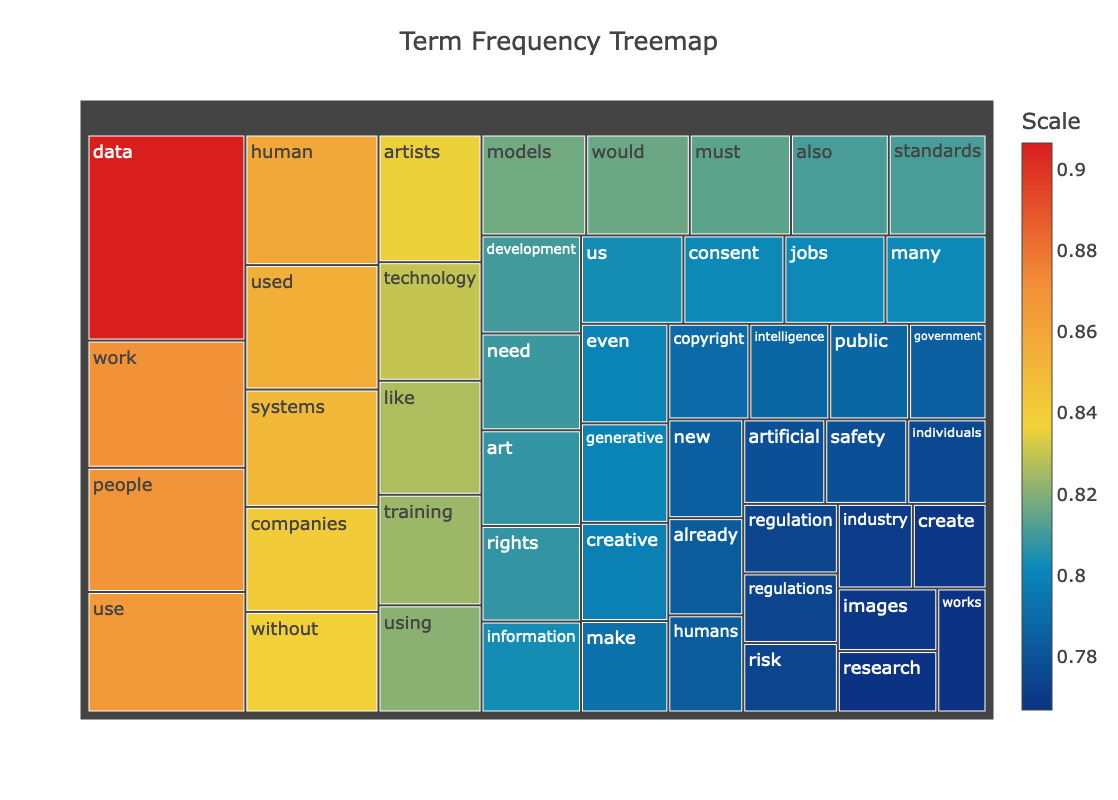

In [206]:
# Create a treemap using plotly express
fig = px.treemap(wdf, path=['Word'], values='Count', color='Scale',
                 color_continuous_scale='Portland',
                 title='Term Frequency Treemap', 
                 width=850, height=800, 
                 template='presentation',
                )

# Show the plot
fig.show()

## Find common topics across documents

In [295]:
dictionary.doc2bow('ai is here to stay forever'.split())

[(230, 1), (2056, 1), (4685, 1)]

In [305]:
print(vectorizer.transform(['ai is here to stay stay']))

  (0, 230)	1
  (0, 4685)	2


In [399]:
num_topics = 4  # Specify the number of topics you want to extract
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
X_topics = lda.fit_transform(X)


In [400]:
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-150 - 1:-1]]))
    print()

Topic #1:
ai standards human governance systems robots development ieee swf super robot intelligent future innovation p2874 humans web spatial organizations working open risk intelligence sociotechnical trustworthy industry government technology artificial world level one second develop rights attachment health system public race enable people technical safety regulatory like new house next attached foundation control comments large two companies need including us build sizes approaches use management 2023 identified key activities may also adoption small years brain leaders work association group national internet developing generation would question autonomous training imperative laws states areas multistakeholder g7 virtual 30 commitments year united area time activity summary white regulation testing copyright benefits research law critical information ideas good real emerging hiv agile sandbox prometheus inferences provided methods regulators currently global priorities solve resp

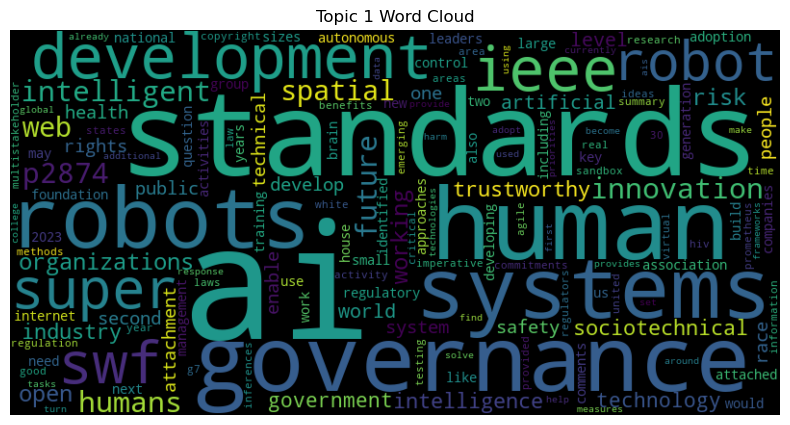

In [403]:
# Visualize the first topic using matplotlib
topic_index_to_visualize = 0

topic_words = dict(zip(vectorizer.get_feature_names_out(), lda.components_[topic_index_to_visualize]))

# Sort words by their weights in the topic
topic_words = dict(sorted(topic_words.items(), key=lambda x: x[1], reverse=True)[:150])

wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(topic_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Topic {topic_index_to_visualize + 1} Word Cloud')
plt.axis('off')
plt.show()

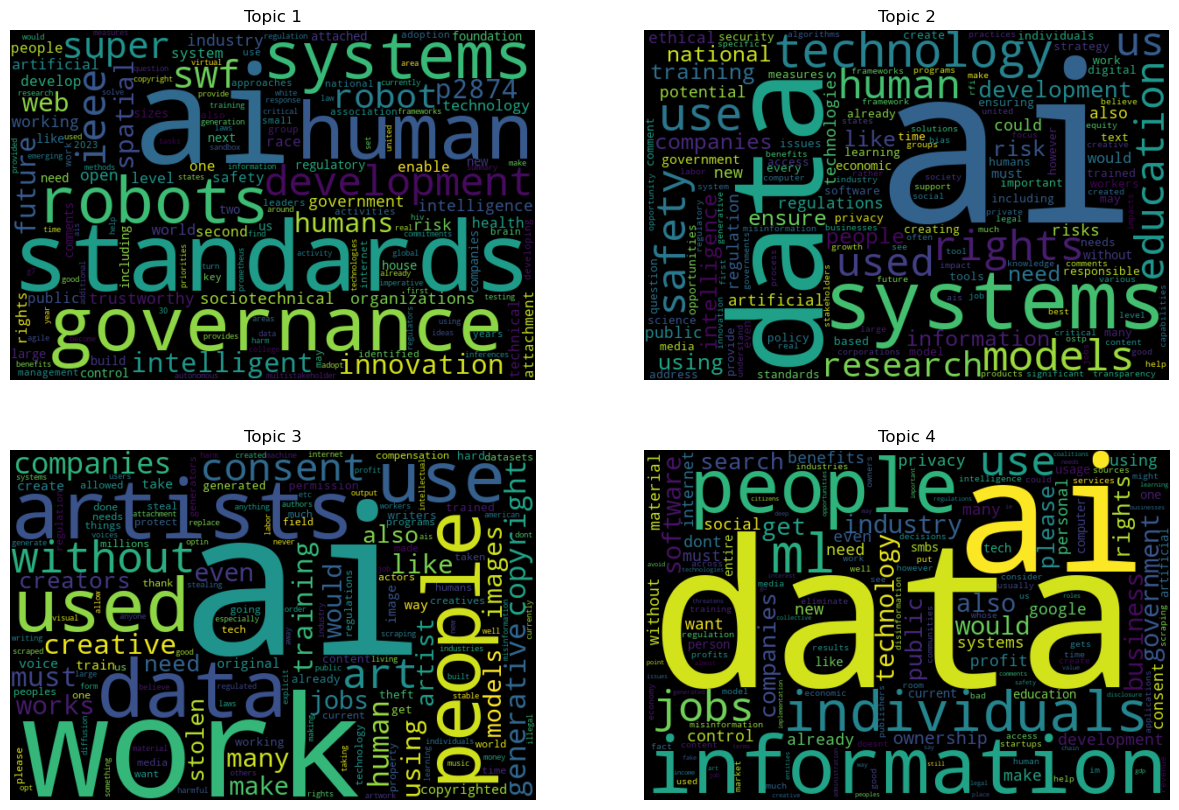

In [405]:
# Visualize the topics using matplotlib
num_topics = lda.n_components

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < num_topics:
        topic_words = dict(zip(vectorizer.get_feature_names_out(), lda.components_[i]))
        
        # Sort words by their weights in the topic
        topic_words = dict(sorted(topic_words.items(), key=lambda x: x[1], reverse=True)[:150])
        wordcloud = WordCloud(width=600, 
                              height=400, 
                              background_color='black').generate_from_frequencies(topic_words)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Topic {i + 1}')
        ax.axis('off')

plt.show()

In [364]:
# Step 4: Create a dictionary and a corpus needed for LDA
terms = vectorizer.get_feature_names_out()
dictionary = corpora.Dictionary([terms])

# Convert the comments into a bag-of-words representation
corpus = [dictionary.doc2bow(comment.split()) for comment in comments]

# Step 5: Perform LDA
lda_model = models.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=30)

# Step 6: Visualize topics using matplotlib
topics = lda_model.show_topics(num_topics=4, num_words=150, formatted=False)
for topic in topics:
    print(f"Topic {topic[0]}: {' '.join([word[0] for word in topic[1]])}")

Topic 0: data used work human use people like creative training also without must would companies copyrighted generated already using systems works need many jobs even generative made create art original programs risk comment get working consent technology train built new development creators artist artists especially due stolen text time material process needs models business way makes computer take consider much person images currently could existing one regulation trained various output personal protect based industry make content large allowed entire big music may information anyone rights ensure issue technologies similar responsible see different making others datasets intellectual private legal social image future input existential might provide something small theft come risks going first well scraping policies important done often product multiple order generate creatives support completely specific affected products hard illegal humans involved thing field market supply taken

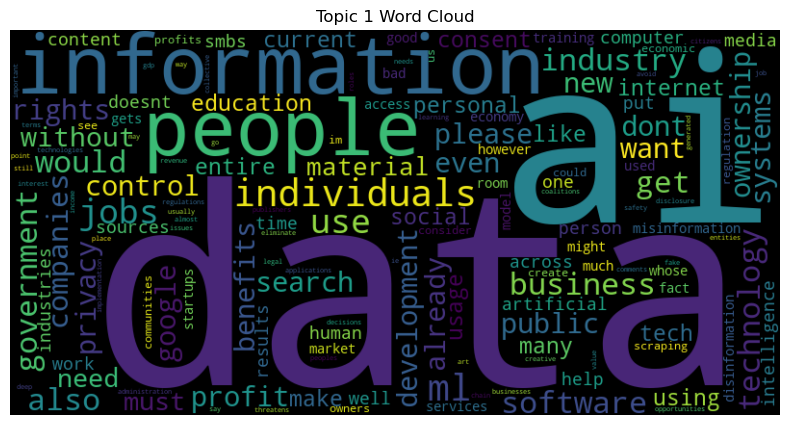

In [379]:
# Visualize the first topic using matplotlib
topic_index_to_visualize = 0

#topic_words = dict(zip(vectorizer.get_feature_names_out(), lda.components_[topic_index_to_visualize]))

# Sort words by their weights in the topic
topic_words = dict(sorted(topic_words.items(), key=lambda x: x[1], reverse=True)[:150])

wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(topic_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Topic {topic_index_to_visualize + 1} Word Cloud')
plt.axis('off')
plt.show()

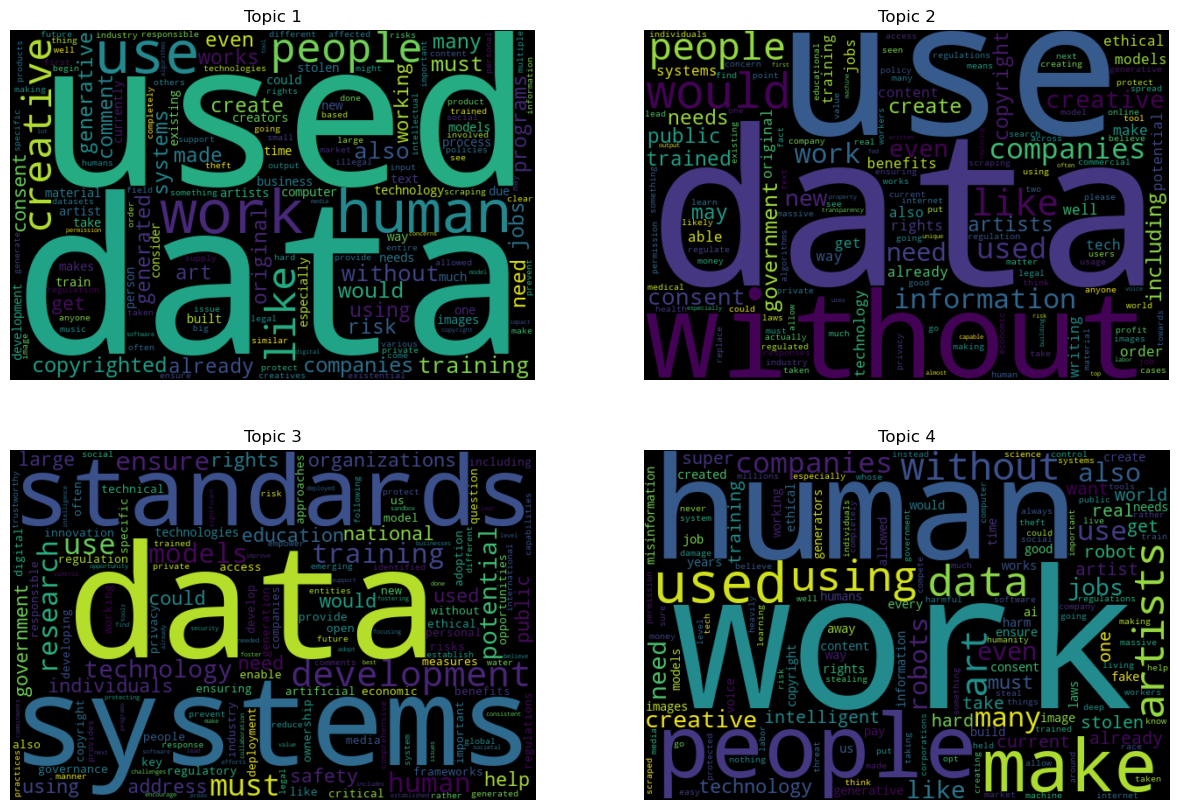

In [381]:
# Visualize the topics using matplotlib
num_topics = 4

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < num_topics:
        topic_words = dict(lda_model.show_topic(i, 150))
        wordcloud = WordCloud(width=600, height=400, background_color='black').generate_from_frequencies(topic_words)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Topic {i + 1}')
        ax.axis('off')

plt.show()

## Summarization (generalized and based on keyword)

In [261]:
def extractive_summarization_with_keyword(document, keyword=None, num_sentences=3):
    # Tokenize the document into sentences
    sentences = sent_tokenize(document)

    # Create TF-IDF matrix
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Calculate cosine similarity between sentences and keyword
    if keyword:
        keyword_vector = vectorizer.transform([keyword])
        similarity_scores = cosine_similarity(tfidf_matrix, keyword_vector)
        # Combine similarity scores with sentence scores
        combined_scores = similarity_scores.flatten()
        # Use PageRank algorithm to rank sentences based on combined scores
        ranked_sentences = [(score, sentence) for score, sentence in zip(combined_scores, sentences)]
        
    else:
        # Calculate cosine similarity between sentences
        similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
        # Use PageRank algorithm to rank sentences
        scores = similarity_matrix.sum(axis=1)
        ranked_sentences = [(score, sentence) for score, sentence in zip(scores, sentences)]
    
    
    ranked_sentences.sort(reverse=True)

    # Select the top N sentences for the summary
    summary_sentences = [sentence for _, sentence in ranked_sentences[:num_sentences]]
    summary = ' '.join(summary_sentences)

    return summary

In [262]:
comments = dfComments['Comment']

In [263]:
text = ' '.join(comments)

In [264]:
extractive_summarization_with_keyword(text, 'privacy')

'Privacy is being violated. Data Privacy: As AI systems often rely on massive amounts of data, data privacy becomes a paramount concern. (5) Enhanced Data Privacy and Security: Measures should be taken to protect the privacy and security of personal data used by AI systems.'

## Bonus:
### As you saw, some submissions had their comments in an attached file. If you are curious as to how we could programatically download these files, I'll leave the code below for you to revise on your own time.

In [39]:
for index, row in dfComments[dfComments['sentiment'] <-.3].iterrows():
    print(row['Attachment Files'])
    print('\n')

nan


nan


https://downloads.regulations.gov/OSTP-TECH-2023-0007-0264/attachment_1.pdf


https://downloads.regulations.gov/OSTP-TECH-2023-0007-0344/attachment_1.pdf




In [41]:
# Define the folder to save the downloaded files
output_folder = 'downloaded_attachments'
os.makedirs(output_folder, exist_ok=True)

In [50]:
def download_and_save(url):
    try:
        if pd.notna(url):  # Skip NaN values
            # Split comma-separated URLs
            urls = [u.strip() for u in url.split(',')]
            
            for u in urls:
                response = requests.get(u)
                if response.status_code == 200:
                    # Generate a random filename using uuid
                    random_filename = str(uuid.uuid4()) + '.pdf'
                    filename = os.path.join(output_folder, random_filename)
                    with open(filename, 'wb') as file:
                        file.write(response.content)
                    print(f'Successfully downloaded: {u} as {random_filename}')
                else:
                    print(f'Failed to download: {u} - Status Code: {response.status_code}')
        else:
            print('Skipping NaN value.')
    except Exception as e:
        print(f'Error downloading {url}: {e}')

In [51]:
# Apply the download_and_save function to each URL in the DataFrame
df['Attachment Files'].apply(download_and_save)

Skipping NaN value.
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0002/attachment_1.pdf as 62636128-62a5-4f91-8618-2168ea517e46.pdf
Skipping NaN value.
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0004/attachment_1.pdf as fad838fc-7234-4a13-bb66-3f99c609f581.pdf
Skipping NaN value.
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0006/attachment_1.pdf as d14973e7-14d3-4a56-b463-5fced203ac7f.pdf
Skipping NaN value.
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0008/attachment_1.pdf as fd99808f-376f-4bac-a18f-4a1cf3fe342a.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0008/attachment_1.docx as 953abf1c-1813-4348-b182-659f48f4ac66.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0009/attachment_1.pdf as 26030e62-2c7d-4962-8f43-bc752eff7458.pdf
Skipping NaN value.
Skipping NaN value.
Skipping 

Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0072/attachment_6.pdf as 13ba3529-ad00-495c-a2e0-ec3c2c7c7221.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0072/attachment_4.pdf as fadbae86-4462-4771-bf0a-26a069416126.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0072/attachment_2.pdf as 5ebc6c2b-89d3-487a-aa88-27bf3b4a816a.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0072/attachment_12.pdf as b23821f7-390b-4acd-9427-0b80b4cb5907.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0072/attachment_13.pdf as e0cd2af8-798d-401c-968f-ca31cde088ef.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0072/attachment_9.pdf as 51e545fb-c1e1-4bf5-905b-854db9553708.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0072/attachment_7.pdf as 3beda1bb-fc86-4257-86e3-

Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0180/attachment_1.pdf as 86782b05-a897-4bc4-bb8e-e4013c541553.pdf
Skipping NaN value.
Skipping NaN value.
Skipping NaN value.
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0184/attachment_1.pdf as bfd44c84-776c-434a-a8a5-9adbdd123cb0.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0184/attachment_2.pdf as d051af6a-70cf-4bf3-b236-4a2118449bb2.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0185/attachment_1.pdf as cd7c35aa-7b62-4636-abac-af098fd8a1f6.pdf
Skipping NaN value.
Skipping NaN value.
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0188/attachment_1.pdf as c6059f4d-f630-414e-8d29-ddbdfd173d6b.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0189/attachment_1.pdf as 62b73d99-b506-426b-ac36-bc8ad883019a.pdf
Successfully downloaded: https

Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0241/attachment_2.pdf as 5f8d80e8-f01f-4310-addf-296d683da929.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0241/attachment_1.pdf as fdb41e35-33e2-4ce3-9e29-ebc9c3698aa3.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0242/attachment_1.pdf as fe14e499-fc93-4224-90be-c1665a352705.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0243/attachment_1.pdf as d6ba2009-910f-4397-8255-340a2a74bbf5.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0244/attachment_1.docx as 689c03b0-de1d-4e07-a53a-2e53fd6fdeaa.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0244/attachment_1.pdf as 74225f1c-765c-460b-af4c-05dde75f3c54.pdf
Skipping NaN value.
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0246/attachment_1.pdf as 0b5ce

Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0285/attachment_1.pdf as b1667e75-f136-4099-9815-449659f3014b.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0286/attachment_1.pdf as c9bd3587-fff3-453f-9186-a8061153f5e6.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0287/attachment_1.pdf as 5798e76a-3499-4685-93d6-9d67bad11c50.pdf
Skipping NaN value.
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0289/attachment_1.pdf as b2c72e99-2d49-4af0-8ec1-d2fad6036c59.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0290/attachment_1.pdf as 20331900-63c4-4d00-997f-9a8c683f6aa6.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0291/attachment_2.pdf as 906c43ef-61cc-4fef-812b-2e8f578d71cb.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0291/attachment_3.pdf as f497cc

Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0342/attachment_1.pdf as 23db1e08-07ec-4e6a-bf42-4bd6fd82acdc.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0343/attachment_1.pdf as 444f26a4-ee21-44ed-b78d-3bcc1944f0c9.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0344/attachment_1.pdf as 34546c20-e04d-4610-a467-37a040703036.pdf
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0345/attachment_1.pdf as 199d1104-d6bc-43c4-b52e-07f52c025399.pdf
Skipping NaN value.
Skipping NaN value.
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0348/attachment_1.pdf as b0b4d954-2dc7-4f2b-9dd5-7a040f84bc33.pdf
Skipping NaN value.
Skipping NaN value.
Successfully downloaded: https://downloads.regulations.gov/OSTP-TECH-2023-0007-0351/attachment_1.pdf as 9ce100fb-3265-4328-af92-9b66b7cbefa3.pdf
Successfully downloaded: https://downloads.regulat

0      None
1      None
2      None
3      None
4      None
       ... 
381    None
382    None
383    None
384    None
385    None
Name: Attachment Files, Length: 386, dtype: object